# Análisis precios Airbnb (Barcelona)

### Importación de librerías

In [108]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from urllib.parse import quote_plus
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import csv


### Visión general del dataset

In [80]:
df = pd.read_csv("listings.csv")
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 19410 entries, 0 to 19409
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            19410 non-null  int64  
 1   listing_url                                   19410 non-null  str    
 2   scrape_id                                     19410 non-null  int64  
 3   last_scraped                                  19410 non-null  str    
 4   source                                        19410 non-null  str    
 5   name                                          19410 non-null  str    
 6   description                                   18673 non-null  str    
 7   neighborhood_overview                         8986 non-null   str    
 8   picture_url                                   19410 non-null  str    
 9   host_id                                       19410 non-null  int64  
 1

Vemos un datasets extenso, con muchas columnas y muchas de ellas con presencia de valores nulos. Nuestro primer paso será seleccionar las columnas que vayamos a utilizar en nuestro análisis posterior, con el fin de no utilizar esfuerzos en limpieza de columnas irrelevantes: 

In [81]:
df.columns.to_list()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30

In [82]:
# Definimos la lista exacta de columnas que aportan valor al modelo
columnas_seleccionadas = [
    'id',
    'listing_url',
    'neighbourhood_cleansed',  #
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    'bathrooms_text',         
    'bedrooms',
    'beds',
    'amenities',
    'price', #variable target
    'minimum_nights',
    'availability_365',
    'number_of_reviews',
    'review_scores_rating',
    'host_is_superhost'
]

#Creamos el dataset
df_airbnb = df[columnas_seleccionadas].copy()

df_airbnb.head()

,id,listing_url,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,availability_365,number_of_reviews,review_scores_rating,host_is_superhost
0,18674,https://www.airbnb.com/rooms/18674,la Sagrada Família,41.405560,2.17262,Entire rental unit,Entire home/apt,8,2 baths,3.0,6.0,"[""Pets allowed"", ""30 inch TV"", ""Coffee maker"",...",$210.00,1,80,51,4.34,f
1,23197,https://www.airbnb.com/rooms/23197,el Besòs i el Maresme,41.412432,2.21975,Entire rental unit,Entire home/apt,5,2 baths,3.0,4.0,"[""Electric stove"", ""Toaster"", ""Wine glasses"", ...",$285.00,3,289,91,4.82,t
2,32711,https://www.airbnb.com/rooms/32711,el Camp d'en Grassot i Gràcia Nova,41.405660,2.17015,Entire rental unit,Entire home/apt,6,1.5 baths,2.0,3.0,"[""Coffee maker"", ""Elevator"", ""Patio or balcony...",$170.00,1,64,152,4.46,f
3,34241,https://www.airbnb.com/rooms/34241,el Barri Gòtic,41.380620,2.17517,Entire condo,Entire home/apt,2,1 bath,1.0,1.0,"[""Toaster"", ""Coffee maker"", ""Bidet"", ""Ethernet...",$110.00,31,333,25,4.36,f
4,34981,https://www.airbnb.com/rooms/34981,el Barri Gòtic,41.379780,2.17623,Entire rental unit,Entire home/apt,9,3 baths,4.0,6.0,"[""Dryer"", ""Cleaning available during stay"", ""C...",$333.00,5,335,271,4.57,f


Vamos a comprobar el tipo de dato y los valores nulos de las columnas de las columnas: 

In [83]:
df_airbnb.info()

<class 'pandas.DataFrame'>
RangeIndex: 19410 entries, 0 to 19409
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      19410 non-null  int64  
 1   listing_url             19410 non-null  str    
 2   neighbourhood_cleansed  19410 non-null  str    
 3   latitude                19410 non-null  float64
 4   longitude               19410 non-null  float64
 5   property_type           19410 non-null  str    
 6   room_type               19410 non-null  str    
 7   accommodates            19410 non-null  int64  
 8   bathrooms_text          19399 non-null  str    
 9   bedrooms                17446 non-null  float64
 10  beds                    15228 non-null  float64
 11  amenities               19410 non-null  str    
 12  price                   15276 non-null  str    
 13  minimum_nights          19410 non-null  int64  
 14  availability_365        19410 non-null  int64  
 

### Limpieza de datos

A continuación, vamos a prodecer con la limpieza de datos. Entre los principales problemas que nos encontramos: 
* Columna "price": es la columna target. Presenta valores nulos y su tipo de datos es "str" debido a que contiene el caracter "$". 
* Columna "bathrooms_text": transformación del número de bathrooms a float ("1.5 bathrooms")


#### Limpieza columna "bathrooms_text"

Antes de empezar con la limpieza, vamos a investigar que valores distintos encontramos en la columna para luego adoptar la estrategia que mejor nos sirva: 

In [84]:
# Mostramos todos los valores distintosd de la columna
print(df_airbnb['bathrooms_text'].unique())

<StringArray>
[          '2 baths',         '1.5 baths',            '1 bath',
           '3 baths',     '1 shared bath',         '3.5 baths',
    '1 private bath',           '4 baths',           '0 baths',
  '1.5 shared baths',         '2.5 baths',         '4.5 baths',
                 nan,           '6 baths',         '5.5 baths',
    '0 shared baths', 'Private half-bath',  '2.5 shared baths',
         'Half-bath',    '2 shared baths',         '7.5 baths',
           '5 baths',    '3 shared baths',    '8 shared baths',
    '4 shared baths',  'Shared half-bath',  '3.5 shared baths',
           '8 baths',    '5 shared baths',          '10 baths',
           '9 baths',    '7 shared baths',          '12 baths',
           '7 baths',          '16 baths',    '6 shared baths',
          '14 baths',          '13 baths',          '11 baths']
Length: 39, dtype: str


Vemos que no podemos separar simplemente por el espacio porque hay valores que no mostrarían el valor ("shared half-bath) asi que lo haremos de la siguiente manera: 

In [85]:
# 1. Manejar los valores "extraños"
df_airbnb["bathrooms_text"] = df_airbnb["bathrooms_text"].str.replace("Half-bath", "0.5", case=False)
df_airbnb["bathrooms_text"] = df_airbnb["bathrooms_text"].str.replace("Private half-bath", "0.5", case=False)
df_airbnb["bathrooms_text"] = df_airbnb["bathrooms_text"].str.replace("Shared half-bath", "0.25", case=False)

# 2. Extracción del número
df_airbnb["bathrooms_clean"] = df_airbnb["bathrooms_text"].str.extract(r'(\d+\.?\d*)')

# 3. Cambio de tipo 
df_airbnb["bathrooms_clean"] = df_airbnb["bathrooms_clean"].astype(float)

# 4. Rellenar nulos con la opción más segura
mediana_banos = df_airbnb["bathrooms_clean"].median()
df_airbnb["bathrooms_clean"] = df_airbnb["bathrooms_clean"].fillna(mediana_banos)

# 5. Verificación
print(df_airbnb[["bathrooms_text", "bathrooms_clean"]].head(10))


  bathrooms_text  bathrooms_clean
0        2 baths              2.0
1        2 baths              2.0
2      1.5 baths              1.5
3         1 bath              1.0
4        3 baths              3.0
5  1 shared bath              1.0
6         1 bath              1.0
7         1 bath              1.0
8        2 baths              2.0
9      3.5 baths              3.5


In [86]:
# Eliminación del columna que no nos sirve ya
df_airbnb.drop(columns=['bathrooms_text'], inplace=True)

#### Limpieza columna "price"

Como hemos señalado antes deberemos eliminar el carácter "$", cambiar el tipo y manejar los nulos

In [87]:
# 1. Eliminar símbolo "$"
df_airbnb['price'] = df_airbnb['price'].str.replace('$', '', regex=False)

# 2. Eliminar , en precios grandes
df_airbnb['price'] = df_airbnb['price'].str.replace(',', '', regex=False)

# 3. Convertir a float
df_airbnb['price'] = df_airbnb['price'].astype(float)

# --- VERIFICACIÓN ---
print(df_airbnb['price'].dtype) # Debería decir 'float64'

print(df_airbnb['price'].describe())

float64
count    15276.000000
mean       187.312713
std        363.967170
min          9.000000
25%         70.000000
50%        131.000000
75%        215.000000
max      10000.000000
Name: price, dtype: float64


Vale, aqui observamos varios puntos clave: 
* Presencia de outliers (10.000$ por una noche) o es un error o es un apartamento de lujo. Hay que gestionarlo. 
* Incapacidad para comparar entre alojamientos. El precio hace referencia al precio por noche del apartamento entero pero cada apartamento dividirá el coste entre las personas que puede alojar. Para poder comparar, tendremos que crear una nueva columna que mida el precio por noche por persona: 

In [88]:
# Asegurarnos de que no hay divisiones por cero 
df_airbnb = df_airbnb[df_airbnb['accommodates'] > 0]

# Crear la columna de Precio por Persona y Noche
df_airbnb['price_pp'] = df_airbnb['price'] / df_airbnb['accommodates']

# Ver estadísticas de esta nueva métrica
print("--- PRECIO POR PERSONA Y NOCHE ---")
print(df_airbnb['price_pp'].describe())

--- PRECIO POR PERSONA Y NOCHE ---
count    15276.000000
mean        53.077936
std         97.178374
min          1.777778
25%         29.000000
50%         40.000000
75%         58.430804
max       4999.500000
Name: price_pp, dtype: float64


De acuerdo, ahora gestionamos los valores nulos de esta columna. Como no podemos inventarnoslos (porque es la columna target y sino luego nuestro modelo no sería real) los eliminamos: 

In [89]:
# Eliminación de valores nulos
df_airbnb = df_airbnb.dropna(subset=['price', 'accommodates', 'price_pp'])



Para gestionar los outliers, eliminaremos los valores por extremos por encima y debajo del percentil 99 y 1. 

In [90]:
# 2. CALCULAR LÍMITES (Percentiles 1% y 99%)
min_logico = df_airbnb['price_pp'].quantile(0.01)
max_logico = df_airbnb['price_pp'].quantile(0.99)


# Nos quedamos solo con lo que está dentro de esos límites
df_clean = df_airbnb[
    (df_airbnb['price_pp'] >= min_logico) & 
    (df_airbnb['price_pp'] <= max_logico)
].copy()

# 4. Resultado
print("\n--- ESTADÍSTICAS TRAS LIMPIEZA ---")
print(df_clean['price_pp'].describe())




--- ESTADÍSTICAS TRAS LIMPIEZA ---
count    14970.000000
mean        47.465260
std         27.522413
min         11.833333
25%         29.250000
50%         40.000000
75%         58.000000
max        220.000000
Name: price_pp, dtype: float64


Vemos que ahora: 
* Ya no hay alquileres a 5.000 euros la noche ni a 1. 
* La desv. estándar ha bajado de 97 a 27 por lo que nuestros datos son mucho más estables. 

#### Limpieza de otras columnas

Para solucionar los valores nulos de otras columnas, vamos a intentar pensar con lógica de negocio con el objetivo de lograr el máximo realismo. Asi pués: 
* **Columna "bedrooms" y "beds":** Supondremos que si no tiene es que es un estudio, por lo que le pondremos 1 a ambas columnas.  
* **Columna "rating":** Para no perjudicar a apartamentos nuevos que igual aún no tienen, lo rellenaremos con la mediana. 
* **Coluna "host_is_superHost":** Como serlo es algo difícil y hay que ganárselo, si es null diremos que no lo es. Además, lo convertiremos a binario para usarlo posteriormente. 

In [91]:
# --- 1. LIMPIEZA DE CAMAS Y HABITACIONES ---
df_clean['bedrooms'] = df_clean['bedrooms'].fillna(1)
df_clean['beds'] = df_clean['beds'].fillna(1)

# --- 2. LIMPIEZA DE RATING (Puntuación) ---
mediana_rating = df_clean['review_scores_rating'].median()
df_clean['review_scores_rating'] = df_clean['review_scores_rating'].fillna(mediana_rating)


# --- 3. LIMPIEZA DE SUPERHOST ---
# Rellenar nulos
df_clean['host_is_superhost'] = df_clean['host_is_superhost'].fillna('f')

# Convertir a binario
df_clean['host_is_superhost'] = df_clean['host_is_superhost'].map({'t': 1, 'f': 0})

# --- VERIFICACIÓN FINAL ---
df_clean.info()

<class 'pandas.DataFrame'>
Index: 14970 entries, 0 to 19409
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      14970 non-null  int64  
 1   listing_url             14970 non-null  str    
 2   neighbourhood_cleansed  14970 non-null  str    
 3   latitude                14970 non-null  float64
 4   longitude               14970 non-null  float64
 5   property_type           14970 non-null  str    
 6   room_type               14970 non-null  str    
 7   accommodates            14970 non-null  int64  
 8   bedrooms                14970 non-null  float64
 9   beds                    14970 non-null  float64
 10  amenities               14970 non-null  str    
 11  price                   14970 non-null  float64
 12  minimum_nights          14970 non-null  int64  
 13  availability_365        14970 non-null  int64  
 14  number_of_reviews       14970 non-null  int64  
 15  r

### Creación de nuevas métricas

Con el objetivo de obtener información más relevante de cara a la construcción del modelo vamos a construir nuevas métricas a partir de las columnas de las que disponemos: 
* **bathrooms_per_person:** seguirá la fórmula número_de_baños / accommodates. Suponemos que a mayor ratio, mayor precio.
* **distance_to_center:** calcularemos la distancia al punto 0 de la ciudad (Plaza Catalunya). A menor distancia, más precio. 
* **amenities_count:** contaremos cuántos elementos hay en la lista de amenities. Suponemos que a mayor cantidad de extras, mayor precio. 
* **luxury_score:** una métrica que contemplará la apración de palabras clave en la lista de "amenities" como "air conditioning, pool, jacuzzi...

In [92]:
# --- RATIO DE BAÑOS ---
df_clean['bathrooms_per_person'] = df_clean['bathrooms_clean'] / df_clean['accommodates']

# --- DISTANCIA AL CENTRO ---
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radio de la Tierra en km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

lat_centro = 41.387385
lon_centro = 2.168568

df_clean['distance_center_km'] = haversine_distance(
    df_clean['latitude'], df_clean['longitude'],
    lat_centro, lon_centro
)

# --- CONTEO DE AMENITIES ---
df_clean['amenities_count'] = df_clean['amenities'].str.count(',') + 1

# --- LUXURY SCORE ---
df_clean['has_ac'] = df_clean['amenities'].str.lower().str.contains('air conditioning').astype(int)
df_clean['has_elevator'] = df_clean['amenities'].str.lower().str.contains('elevator').astype(int)
df_clean['has_pool'] = df_clean['amenities'].str.lower().str.contains('pool').astype(int)
df_clean['has_parking'] = df_clean['amenities'].str.lower().str.contains('parking').astype(int)
df_clean['has_jacuzzi'] = df_clean['amenities'].str.lower().str.contains('jacuzzi').astype(int)

# --- VISUALIZAR RESULTADOS ---
print(df_clean[['price', 'distance_center_km', 'bathrooms_per_person', 'amenities_count', 'has_ac']].head())

   price  distance_center_km  bathrooms_per_person  amenities_count  has_ac
0  210.0            2.049036              0.250000               22       0
1  285.0            5.097195              0.400000               54       0
2  170.0            2.036367              0.250000               40       0
3  110.0            0.932328              0.500000               32       1
4  333.0            1.060060              0.333333               40       1


### Modelo de Machine Learning

Un aspecto clave de nuestro proyecto es crear un modelo de machine learning, que, sacando información de los atributos de cada piso prediga cuanto debería costar, con el objetivo de poder compararlo con el precio real que tiene y asi comprobar si un piso está sobrevalorado o infravalorado. Para ello, añadiremos dos columnas a nuestro dataset: 
* **precio_predecido:** el valor que estime nuestro modelo que debe valer
* **precio_diff:** la diferencia de precio entre el valor real y el estimado


#### Preparación de datos para el modelo

Aqui vamos a seleccionar que columnas vamos a usar como predictores y prepararlas para poder usarlas. 

In [93]:
# 1. Selección de columnas
cols_ignorar = ['id', 'listing_url', 'amenities', 'price_pp']

# 2. División de variables
X = df_clean.drop(columns=['price'] + [c for c in cols_ignorar if c in df_clean.columns])

y = df_clean['price']

# 3. Conversión de variables categóricas a núméricas (One - hot - encoder)
X = pd.get_dummies(X, columns=['neighbourhood_cleansed', 'property_type', 'room_type'], drop_first=True)

#### Entrenamiento del modelo



In [94]:
# 1. División de los datos en muestra de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Entrenamiento del modelo
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

#### Evaluación del modelo

Vamos a evaluar nuestro modelo atendiendo a dos métricas: 

+ **Error absoluto medio (MAE):** muchos más interpretable en unidades de negocio y menos sensible a outliers. 
+ **Margen de error relativo(%):** dado que el rango de precios es muy amplio, el error porcentual permite evaluar la calidad de la predicción independientemente del la magnitud del precio. 

In [95]:
# Hacemos predicciones sobre la muestra de prueba
predicciones_test = rf.predict(X_test)

# Calculamos el error
mae = mean_absolute_error(y_test, predicciones_test)
precio_medio = y_test.mean()

print(f"\n--- RESULTADOS ---")
print(f"Precio medio real: {precio_medio:.2f}€")
print(f"Error medio del modelo (MAE): {mae:.2f}€")
print(f"Margen de error: {(mae/precio_medio)*100:.1f}%")


--- RESULTADOS ---
Precio medio real: 169.28€
Error medio del modelo (MAE): 40.64€
Margen de error: 24.0%


Como vemos, tanto el MAE como el margen de error son bastante altos, lo que hará que nuestas predicciones sean poco precisas pudiendo aportar poco valor de mercado. Por ello, para conseguir disminuir ese error, vamos a:
* Ajustar los hiperparámetros de nuestro modelo (a través de validación cruzada)
+ Eliminar posibles outliers que añaden ruido a nuestro entrenamiento (price > 500)

In [96]:
# 1. Definición de parámetros a probar
param_grid = {
    'n_estimators': [100, 200, 300, 500],        
    'max_depth': [10, 20, 30, None],             
    'min_samples_split': [2, 5, 10],            
    'min_samples_leaf': [1, 2, 4],             
    'max_features': ['sqrt', 'log2', None]      
}

# 2. COnfigurar el buscador

rf_base = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(
    estimator=rf_base, 
    param_distributions=param_grid, 
    n_iter=20, 
    cv=3, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1, 
    scoring='neg_mean_absolute_error' # Buscamos minimizar el error absoluto (MAE)
)

# 3. Entrenar el buscador
rf_random.fit(X_train, y_train)

# 4. RESULTADOS
print("MEJORES PARÁMETROS ENCONTRADOS:")
print(rf_random.best_params_)



Fitting 3 folds for each of 20 candidates, totalling 60 fits
MEJORES PARÁMETROS ENCONTRADOS:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}


Ahora que hemos encontrado los mejores hiperparámetros, eliminaremos el ruido y configuraremos de nuevo nuestro arbol para disminuir el error: 

In [99]:
# 1. Filtrado de filas 
df_optimizado = df_clean[df_clean['price'] <= 500].copy()


# 2. Preparación de datos (idéntico a antes)
cols_a_ignorar = ['id', 'listing_url', 'amenities', 'price_pp', 'bathrooms_per_person', 'price_suggested', 'price_diff', 'price_label']
X = df_optimizado.drop(columns=['price'] + [c for c in cols_a_ignorar if c in df_optimizado.columns])
y = df_optimizado['price']

# One-Hot Encoding de nuevo
X = pd.get_dummies(X, columns=['neighbourhood_cleansed', 'property_type', 'room_type'], drop_first=True)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Modelo con hiperparámetros mejorados
rf_opt = RandomForestRegressor(
    n_estimators=300,  
    max_depth=None,      
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42, 
    n_jobs=-1
)
rf_opt.fit(X_train, y_train)

# 4. Predicciónes nuevas
pred = rf_opt.predict(X_test)
mae_nuevo = mean_absolute_error(y_test, pred)
media_nueva = y_test.mean()

print(f"\n--- RESULTADOS OPTIMIZADOS ---")
print(f"Nuevo MAE: {mae_nuevo:.2f}€")
print(f"Nuevo Margen: {(mae_nuevo/media_nueva)*100:.1f}%")


--- RESULTADOS OPTIMIZADOS ---
Nuevo MAE: 31.71€
Nuevo Margen: 21.6%


!Bien! Aunque no mucho, hemos conseguido disminuir el error. A continuación, presentaremos la lista de las 10 variables que aportan mayor información a la hora de explicar el precio: 

                                      Variable  Importancia
2                                 accommodates     0.358195
5                               minimum_nights     0.166209
117  property_type_Private room in rental unit     0.061988
10                             bathrooms_clean     0.059005
11                          distance_center_km     0.042523
6                             availability_365     0.042157
0                                     latitude     0.041776
1                                    longitude     0.035337
12                             amenities_count     0.032663
7                            number_of_reviews     0.031607


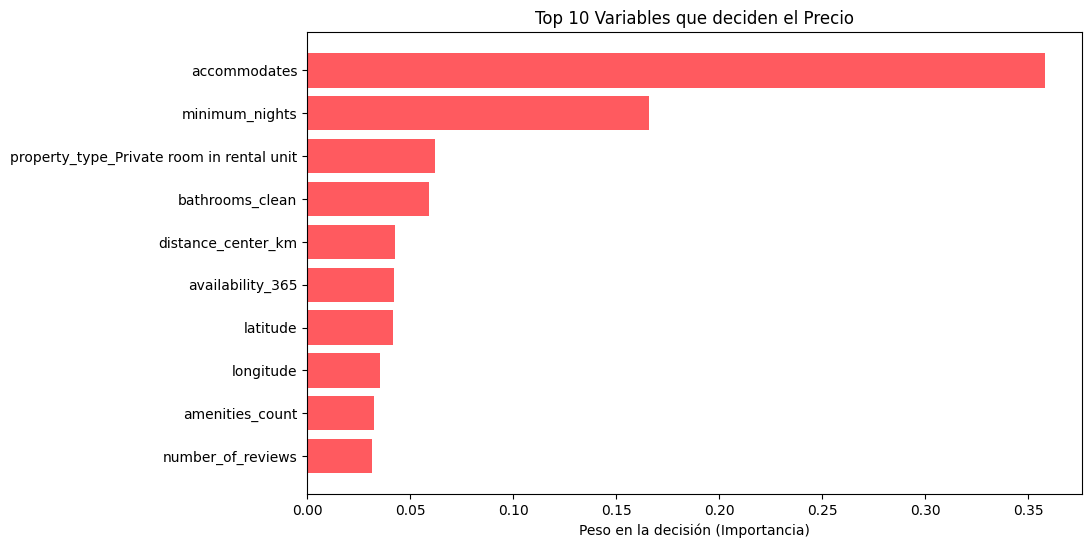

In [103]:
# 1. Obtener el nombre de las columnas
nombres_reales = X_train.columns 

# 2. Obtener la importancia del modelo
importancias = rf_opt.feature_importances_ 

# 3. Crear el dataframe
df_importancia = pd.DataFrame({
    'Variable': nombres_reales, 
    'Importancia': importancias
})

# 4. Ordenar y visualizar
df_importancia = df_importancia.sort_values('Importancia', ascending=False).head(10)


print(df_importancia)

# Gráfico
plt.figure(figsize=(10, 6))
# Invertimos el eje Y para que la más importante salga arriba del todo
plt.barh(df_importancia['Variable'], df_importancia['Importancia'], color='#FF5A5F') 
plt.gca().invert_yaxis() 
plt.title('Top 10 Variables que deciden el Precio')
plt.xlabel('Peso en la decisión (Importancia)')
plt.show()

En la gráfica superior observamos los 10 atributos que explican en mayor medida el precio de un alojamiento: 
+ **accommodates:** tiene mucho sentido. A mayor número de personas mayor tamaño y por tanto mayor precio. 
+ **medidas de localización:** aparecen tanto distancia al centro como la longitud y la latitud. Aunque pueda paracer lo mismo, no es lo mismo estar a 2 km hacia el norte (casas lujosas) que dos km hacia el sur (casas más pobres.)

Por último, nos queda calcular esas nuevas columnas y añadirlas a nuestro dataset, con el objetivo de luego poder incluirlas en nuestro informe visual: 

In [105]:
# 1. Predecimos sobre todos los datos
df_optimizado['price_predecido'] = rf_opt.predict(X)

# 2. Calculamos la DIFERENCIA
# Diferencia = Precio Real - Precio Sugerido
df_optimizado['price_diff'] = df_optimizado['price'] - df_optimizado['price_predecido']

# 3. Clasificamos la oportunidad
def clasificar_precio(fila):
    diff = fila['price_diff']
    sugerido = fila['price_predecido']
    
    # Si es un 20% más barato de lo que debería
    if diff < -(sugerido * 0.2): return 'Infravalorado'
    # Si es un 20% más caro
    elif diff > (sugerido * 0.2): return 'Sobrevalorado'
    else: return 'Precio Justo'

df_optimizado['price_label'] = df_optimizado.apply(clasificar_precio, axis=1)

# Visualizamos
print(df_optimizado[['price', 'price_predecido', 'price_diff', 'price_label']].head(10))

    price  price_predecido  price_diff    price_label
0   210.0       252.034392  -42.034392   Precio Justo
1   285.0       247.348559   37.651441   Precio Justo
2   170.0       167.295323    2.704677   Precio Justo
3   110.0        88.968471   21.031529  Sobrevalorado
4   333.0       346.203890  -13.203890   Precio Justo
6   204.0       209.602229   -5.602229   Precio Justo
7   170.0       180.891751  -10.891751   Precio Justo
8   128.0       154.879980  -26.879980   Precio Justo
9   315.0       266.655679   48.344321   Precio Justo
10  199.0       185.319195   13.680805   Precio Justo


In [110]:
# 1. GUARDAR EL CSV LIMPIO
df_optimizado.to_csv('airbnb_final_upload.csv', index=False, encoding='utf-8', sep=';', quoting=csv.QUOTE_ALL) 

print("Archivo 'airbnb_final_upload.csv' creado.")

# 2. GENERAR EL CÓDIGO PARA CREAR LA TABLA
print(pd.io.sql.get_schema(df_optimizado, 'listings_clean'))


Archivo 'airbnb_final_upload.csv' creado.
CREATE TABLE "listings_clean" (
"id" INTEGER,
  "listing_url" TEXT,
  "neighbourhood_cleansed" TEXT,
  "latitude" REAL,
  "longitude" REAL,
  "property_type" TEXT,
  "room_type" TEXT,
  "accommodates" INTEGER,
  "bedrooms" REAL,
  "beds" REAL,
  "amenities" TEXT,
  "price" REAL,
  "minimum_nights" INTEGER,
  "availability_365" INTEGER,
  "number_of_reviews" INTEGER,
  "review_scores_rating" REAL,
  "host_is_superhost" INTEGER,
  "bathrooms_clean" REAL,
  "price_pp" REAL,
  "bathrooms_per_person" REAL,
  "distance_center_km" REAL,
  "amenities_count" INTEGER,
  "has_ac" INTEGER,
  "has_elevator" INTEGER,
  "has_pool" INTEGER,
  "has_parking" INTEGER,
  "has_jacuzzi" INTEGER,
  "price_predecido" REAL,
  "price_diff" REAL,
  "price_label" TEXT
)
